<img src="https://markdown.data-ensta.fr/uploads/upload_4adc1d5dc22f29b5f5ffe424e5f7978b.gif" alt="drawing" width="600"/>

For now this notebook aims at providing a simple IMU data exploitation to get orientation angles.
First part provides a way to visualize the device's orientation despite there being no RPY angles in the supplemental data. 

#### References
+ Cool pipeline from @robikscube's [notebook](https://www.kaggle.com/code/robikscube/smartphone-competition-2022-twitch-stream);
+ Baseline submission helpers from @saitodevel01's [notebook](https://www.kaggle.com/code/saitodevel01/gsdc2-baseline-submission/notebook);
+ Video embedding in notebook found in @saraivaufc's [answer](https://www.kaggle.com/questions-and-answers/124051).

In [ ]:
# Lovely formatter
!pip install nb_black > /dev/null
%load_ext lab_black

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from glob import glob
from tqdm import tqdm
import plotly.express as px

pd.set_option("max_columns", 500)

In [ ]:
# First fetch training paths
train_gt_paths = glob("../input/smartphone-decimeter-2022/train/*/*/ground_truth.csv")
trip_ids = ["/".join(path.split("/")[-3:-1]) for path in train_gt_paths]

# Orientation
There are no data on the orientation of the device despite these features being mentioned in the data description.
It's shame because I think it's feels good being able to keep an eye on what's really happening to the object of study.
Fortunately we can infer orientation from IMU data.

Figure bellow shows the steps we follow to get $N+1$ $(\alpha, \beta,\gamma)$ degree-rotation-triplets for a trip of $N$ points ($N$ is the minimum number of points where we have simultaneous accelerometer, gyroscope and magnetometer values. Usually, there are less magnetometer values than accelemometer or gyroscope). Note that the first two steps are provided by one function in the notebook: `trip_quaternions`, that takes a `trip_id` and outputs the rotation quaternions to feed the final step.

<center><img src="https://markdown.data-ensta.fr/uploads/upload_f3cd5e98637c1b38a16681c2f0099709.png" alt="drawing" width="800"/></center>

Below are a handful of quaternion and filtering functions, but only `get_xyz_IMU_values` is important;

In [ ]:
def q_mult(q1, q2):
    """Common product of two quaternions.

    Args:
        q1 (ndarray): Quaternion 1.
        q2 (ndarray): Quaternion 2.

    Returns:
        w (float): Real part of product result.
        x (float): 1st imaginary part of product result.
        y (float): 2st imaginary part of product result.
        z (float): 3st imaginary part of product result.

    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z


def q_conjugate(q):
    """Computes conjugate of input quaternion.

    Args:
        q (ndarray): Quaternion.

    Returns:
        conj (tuple): Quaternion conjugate.
    """
    w, x, y, z = q
    conj = (w, -x, -y, -z)
    return conj


def qv_mult(q1, v1):
    """Carries out q * v * q^-1 to rotate v.

    Args:
        q1 (ndarray): Rotation quaternion.
        v1 (ndarray): Rotated vector (point).

    Returns:
        product: Description
    """
    q2 = np.concatenate(([[0]], v1))
    product = q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]
    return product


def axisangle_to_q(v, theta):
    """Get the q quaternion from a (R_axis, R_angle) couple.

    The operation carried out ultimately is q * v * q^-1 to rotate v.

    Args:
        v (ndarray): Rotation axis,
        theta (float): Description

    Returns:
        q (tuple): Rotation quaternion.

    """
    v = normalize(v)
    x, y, z = v
    theta /= 2
    w = np.cos(theta)
    x = x * np.sin(theta)
    y = y * np.sin(theta)
    z = z * np.sin(theta)
    q = (w, x, y, z)
    return q


def q_sanity_check():
    """Just to check sanity of computations. Identity rotation on y axis.

    Examples:
        >>> q_sanity_check()
        (array([0.]), array([1.]), array([0.]))

    """
    x_axis_unit = np.array([1, 0, 0]).reshape(3, 1)
    y_axis_unit = np.array([0, 1, 0]).reshape(3, 1)
    z_axis_unit = np.array([0, 0, 1]).reshape(3, 1)
    r1 = axisangle_to_q(x_axis_unit, np.pi / 2)
    r2 = axisangle_to_q(y_axis_unit, np.pi / 2)
    r3 = axisangle_to_q(z_axis_unit, np.pi / 2)

    v = qv_mult(r1, y_axis_unit)
    v = qv_mult(r2, v)
    v = qv_mult(r3, v)
    print(v)


def get_xyz_IMU_values(trip_id):
    """Get IMU values (one sample = 3 triplets) in a xyz array format thourgh resampling.

    This filter finds, for each gyr sample (frame), the closest-in-time acc and mag sample.
    The output will therefore be exactly the size of the gyr samples.

    Args:
        trip_id (str): ID of a trip (typically date/modelOfPhone).

    Returns:
        (tuple): Three arrays of shape (len(gyr), 3).

    Raises:
        ValueError: If there are less gyr samples than either acc or mag samples.

    """
    imu = pd.read_csv(
        f"../input/smartphone-decimeter-2022/train/{trip_id}/device_imu.csv"
    )

    acc = imu.query(f"MessageType=='UncalAccel'")
    gyr = imu.query(f"MessageType=='UncalGyro'")
    mag = imu.query(f"MessageType=='UncalMag'")

    # The orientation filter will want array data so we manipulate numpy format from now on
    acc_np = acc[["MeasurementX", "MeasurementY", "MeasurementZ"]].to_numpy()
    gyr_np = gyr[["MeasurementX", "MeasurementY", "MeasurementZ"]].to_numpy()
    mag_np = mag[["MeasurementX", "MeasurementY", "MeasurementZ"]].to_numpy()

    # Sampling times
    acc_time, gyr_time, mag_time = (
        acc["utcTimeMillis"].tolist(),
        gyr["utcTimeMillis"].tolist(),
        mag["utcTimeMillis"].tolist(),
    )

    # TODO
    if not (len(gyr_time) < len(acc_time) and len(gyr_time) < len(mag_time)):
        raise ValueError("Gyr is assumed to be of lesser number")

    # The dictionaries will make it easier to get sample values for resampling
    acc_dict = dict(zip(acc_time, (acc_np[:, :])))
    mag_dict = dict(zip(mag_time, (mag_np[:, :])))

    # Resampled values
    selected_acc, selected_mag = [], []

    i = 0

    # For all the gyroscope sample times...
    for gyr_ms in tqdm(list(gyr_np[:, 0])):
        # ...find the closest accelerometer sample time in a window of width 3 values...
        closest_key = min(
            acc_time[np.maximum(i - 3, 0) : i + 3], key=lambda x: abs(x - gyr_ms)
        )
        # ...and save corresponding sample.
        selected_acc.append(list(acc_dict[closest_key]))
        # Same for mag
        closest_key = min(
            mag_time[np.maximum(i - 3, 0) : i + 3], key=lambda x: abs(x - gyr_ms)
        )
        selected_mag.append(list(mag_dict[closest_key]))
        i += 1
    return np.array(selected_acc), gyr_np, np.array(selected_mag)

In [ ]:
!pip install AHRS

In [ ]:
from ahrs.filters import Mahony

# Take example trip
trip_id = trip_ids[10]


def trip_quaternions(trip_id):
    """Fetches quaternions from a trip (Mahony filtering).

    Args:
        trip (dict): Session data from a dump.

    Returns:
        ndarray: Quaternions of input session, of dimension (N_frames, 4).

    """
    acc, gyr, mag = get_xyz_IMU_values(trip_id)

    orientation = Mahony(gyr=gyr, acc=acc, mag=mag, frequency=50.0)  # Using IMU
    return orientation.Q


Q = trip_quaternions(trip_id)

We still need degrees to feed the plot functions;

In [ ]:
def rotations_from_quaternions(trip_q):
    """Convert quaternions from one trip to axial-angles.

    Args:
        trip_q (ndarray): Quaternions of input session, of dimension (N_frames, 4).

    Returns:
        tuple: Three N_frames+1-long lists of rotation angles around each of the three axes.
            The first term of each list is a manually added array([[1], [0], [0]]) for x starters,
            array([[0], [1], [0]]) for y and so on.

    """
    state = {
        "x": [np.array([1, 0, 0]).reshape(3, 1)],  # x axis unit
        "y": [np.array([0, 1, 0]).reshape(3, 1)],  # y axis unit
        "z": [np.array([0, 0, 1]).reshape(3, 1)],
    }  # z axis unit

    for _, q in enumerate(trip_q):
        current_state = qv_mult(q, np.array([0, 0, 1]).reshape(3, 1))
        state["z"].append(current_state)
        current_state = qv_mult(q, np.array([1, 0, 0]).reshape(3, 1))
        state["x"].append(current_state)
        current_state = qv_mult(q, np.array([0, 1, 0]).reshape(3, 1))
        state["y"].append(current_state)

    return (state["x"], state["y"], state["z"])

Bellow are plot functions to plot the orientation of the device during the trip;

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d, art3d
import matplotlib.lines as mlines


class Arrow3D(FancyArrowPatch):

    """Arrow class for 3D plotting of the phone's orientation."""

    def __init__(self, xs, ys, zs, *args, **kwargs):
        """Arrow creator.

        Args:
            xs (ndarray): [start,end] float array of the x coordinates of the arrow.
            ys (ndarray): [start,end] float array of the y coordinates of the arrow.
            zs (ndarray): [start,end] float array of the z coordinates of the arrow.
            *args: Additional arrow parameters passed to FancyArrowPatch.__init__.
            **kwargs: Additional arrow parameters passed to FancyArrowPatch.__init__.
        """
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        """Draws Arrow3D object.

        Args:
            renderer (matplotlib.backend_bases.RendererBase): Renders operations.
        """
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self):
        """Summary

        Args:
            renderer (None, optional): Description
        """
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)


def show_phone_rotations(rx, ry, rz, save_dir, title_data=None):
    """Create all plot instances corresponding to each angular state

    Args:
        rx (ndarray): 3D coordinate of tip of x-axis at every frame of the session.
        ry (ndarray): 3D coordinate of tip of y-axis at every frame of the session.
        rz (ndarray): 3D coordinate of tip of z-axis at every frame of the session.
        save_dir (str): Saving directory.
        title_data (None, optional): Dict for title display.

    """
    for k in tqdm(range(len(rz))):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection="3d")

        # Scale
        plt.autoscale(False)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        # ax.set_axis_off()
        plt.setp(ax.get_xticklabels(), visible=False)

        n = np.array([float(rx[k][0]), float(rx[k][1]), float(rx[k][2])])
        o = np.array([float(ry[k][0]), float(ry[k][1]), float(ry[k][2])])

        # Plot rectangle as phone
        rectangle = {
            "one": tuple(-0.5 * n + 0.7 * o),
            "two": tuple(0.5 * n + 0.7 * o),
            "three": tuple(0.5 * n - 0.7 * o),
            "four": tuple(-0.5 * n - 0.7 * o),
        }

        ax.add_collection(
            art3d.Poly3DCollection(
                [
                    [
                        rectangle["one"],
                        rectangle["two"],
                        rectangle["three"],
                        rectangle["four"],
                    ]
                ],
                alpha=0.5,
            )
        )

        ax.grid(False)
        ax.tick_params(left=False, bottom=False, top=False, labelbottom=False)

        plt.autoscale(False)

        # Plot arrows
        z = Arrow3D(
            [0, float(rz[k][0])],
            [0, float(rz[k][1])],
            [0, float(rz[k][2])],
            mutation_scale=20,
            lw=3,
            arrowstyle="-|>",
            color="r",
        )
        x = Arrow3D(
            [0, float(rx[k][0])],
            [0, float(rx[k][1])],
            [0, float(rx[k][2])],
            mutation_scale=20,
            lw=3,
            arrowstyle="-|>",
            color="#4A4A4A",
        )
        y = Arrow3D(
            [0, float(ry[k][0])],
            [0, float(ry[k][1])],
            [0, float(ry[k][2])],
            mutation_scale=20,
            lw=3,
            arrowstyle="-|>",
            color="#4A4A4A",
        )

        ax.add_artist(z)
        ax.add_artist(x)
        ax.add_artist(y)
        plt.title(f"Trip {title_data['trip']}  timestamp {format(k*0.02,'.2f')} s")
        plt.savefig(f"{save_dir}/{str(k).zfill(4)}.png", dpi=220)
        plt.close()
        k += 1
    plt.clf()

In [ ]:
# Plot sving directory
rotation_dir = "./phone_rotations/"
os.mkdir(rotation_dir)

In [ ]:
# Get degree angles
rx, ry, rz = rotations_from_quaternions(Q)

# You can generate as many plots as there are sample points to view the full trip.
# Here I only generate 100 because it takes a lot of time
show_phone_rotations(
    rx[:100], ry[:100], rz[:100], save_dir=rotation_dir, title_data={"trip": trip_id}
)

In [ ]:
# Creates a video from img files
!cd $rotation_dir && ffmpeg -framerate 50 -i %04d.png out.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode


def play(filename):
    html = ""
    video = open(filename, "rb").read()
    src = "data:video/mp4;base64," + b64encode(video).decode()
    html += (
        '<video width=600 controls autoplay loop><source src="%s" type="video/mp4"></video>'
        % src
    )
    return HTML(html)


play("./phone_rotations/out.mp4")

Note that the first seconds of the filtered measurements are the less accurate (no priors).

TODO
+ Plot trajectory on map besides orientation


# Plotting planar acceleration magnitude: an example

Unit conversion;

In [ ]:
from dataclasses import dataclass
from scipy.interpolate import InterpolatedUnivariateSpline

INPUT_PATH = "../input/smartphone-decimeter-2022"

WGS84_SEMI_MAJOR_AXIS = 6378137.0
WGS84_SEMI_MINOR_AXIS = 6356752.314245
WGS84_SQUARED_FIRST_ECCENTRICITY = 6.69437999013e-3
WGS84_SQUARED_SECOND_ECCENTRICITY = 6.73949674226e-3

HAVERSINE_RADIUS = 6_371_000


@dataclass
class ECEF:
    x: np.array
    y: np.array
    z: np.array

    def to_numpy(self):
        return np.stack([self.x, self.y, self.z], axis=0)

    @staticmethod
    def from_numpy(pos):
        x, y, z = [np.squeeze(w) for w in np.split(pos, 3, axis=-1)]
        return ECEF(x=x, y=y, z=z)


@dataclass
class BLH:
    lat: np.array
    lng: np.array
    hgt: np.array


def ECEF_to_BLH(ecef):
    a = WGS84_SEMI_MAJOR_AXIS
    b = WGS84_SEMI_MINOR_AXIS
    e2 = WGS84_SQUARED_FIRST_ECCENTRICITY
    e2_ = WGS84_SQUARED_SECOND_ECCENTRICITY
    x = ecef.x
    y = ecef.y
    z = ecef.z
    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(z * (a / b), r)
    B = np.arctan2(z + (e2_ * b) * np.sin(t) ** 3, r - (e2 * a) * np.cos(t) ** 3)
    L = np.arctan2(y, x)
    n = a / np.sqrt(1 - e2 * np.sin(B) ** 2)
    H = (r / np.cos(B)) - n
    return BLH(lat=B, lng=L, hgt=H)


def haversine_distance(blh_1, blh_2):
    dlat = blh_2.lat - blh_1.lat
    dlng = blh_2.lng - blh_1.lng
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(blh_1.lat) * np.cos(blh_2.lat) * np.sin(dlng / 2) ** 2
    )
    dist = 2 * HAVERSINE_RADIUS * np.arcsin(np.sqrt(a))
    return dist


def pandas_haversine_distance(df1, df2):
    blh1 = BLH(
        lat=np.deg2rad(df1["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df1["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    blh2 = BLH(
        lat=np.deg2rad(df2["LatitudeDegrees"].to_numpy()),
        lng=np.deg2rad(df2["LongitudeDegrees"].to_numpy()),
        hgt=0,
    )
    return haversine_distance(blh1, blh2)


def ecef_to_lat_lng(tripID, gnss_df, UnixTimeMillis):
    ecef_columns = [
        "WlsPositionXEcefMeters",
        "WlsPositionYEcefMeters",
        "WlsPositionZEcefMeters",
    ]
    columns = ["utcTimeMillis"] + ecef_columns
    ecef_df = (
        gnss_df.drop_duplicates(subset="utcTimeMillis")[columns]
        .dropna()
        .reset_index(drop=True)
    )
    ecef = ECEF.from_numpy(ecef_df[ecef_columns].to_numpy())
    blh = ECEF_to_BLH(ecef)

    TIME = ecef_df["utcTimeMillis"].to_numpy()
    lat = InterpolatedUnivariateSpline(TIME, blh.lat, ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(TIME, blh.lng, ext=3)(UnixTimeMillis)
    return pd.DataFrame(
        {
            "tripId": tripID,
            "UnixTimeMillis": UnixTimeMillis,
            "LatitudeDegrees": np.degrees(lat),
            "LongitudeDegrees": np.degrees(lng),
        }
    )


def calc_score(trip_id, pred_df, gt_df):
    d = pandas_haversine_distance(pred_df, gt_df)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])
    return score

Main plot function;

In [ ]:
def visualize_traffic(
    df,
    lat_col="LatitudeDegrees",
    lon_col="LongitudeDegrees",
    center=None,
    color_col="phone",
    label_col="tripId",
    zoom=40,
    opacity=1,
):
    if center is None:
        center = {
            "lat": df[lat_col].mean(),
            "lon": df[lon_col].mean(),
        }
    fig = px.scatter_mapbox(
        df,
        # Here, plotly gets, (x,y) coordinates
        lat=lat_col,
        lon=lon_col,
        # Here, plotly detects color of series
        color=color_col,
        labels=label_col,
        zoom=zoom,
        center=center,
        height=600,
        width=800,
        opacity=0.5,
    )
    fig.update_layout(mapbox_style="stamen-terrain")
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

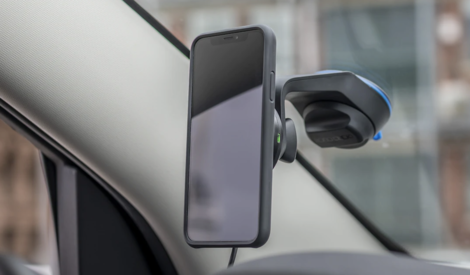

img credit: https://www.quadlockcase.eu/products/quad-lock-car-mount

Below are two functions:
+ one resamples the accelerometer data according to GNSS data;
+ the other plots groundtruth GNSS overlayed with the device's XZ-plane acceleration magnitude (we make the assumption that the device is held vertically for the sake of the experiments);

In [ ]:
def closest_measures(to_resample, reference):
    """Resamples a df to match the sampling time of the reference.

    Uses a sliding-window closest-timestamp.

    Args:
        to_resample (pandas.DataFrame): df to be resampled (time keys utcTimeMillis).
        reference (pandas.DataFrame): Reference df that has lower sample
            frequency (time keys UnixTimeMillis).

    Returns:
        resampled: to_resample dataframe resampled.

    """
    to_resample_time = to_resample["utcTimeMillis"].tolist()
    reference_time = reference["UnixTimeMillis"].tolist()

    ratio = int(len(to_resample_time) / len(reference_time))

    # Resampled values
    selected_resampling_time = []
    i = 0

    print("Resampling...")
    for time in tqdm(reference_time):
        left = max(i * (ratio) - 100, 0)
        right = min((i + 1) * (ratio) + 100, len(to_resample_time))
        closest_time = min(
            to_resample_time[left:right],
            key=lambda x: abs(x - time),
        )
        selected_resampling_time.append(closest_time)
        i += 1
    resampled = to_resample.loc[
        to_resample["utcTimeMillis"].isin(selected_resampling_time)
    ]
    print("Done.")
    return resampled


def plot_gt_acc_magnitude(trip_id, zoom=13):
    """Plots ground-truth colored by planar acceleration magnitude."""
    gt = pd.read_csv(
        f"../input/smartphone-decimeter-2022/train/{trip_id}/ground_truth.csv"
    )
    imu = pd.read_csv(
        f"../input/smartphone-decimeter-2022/train/{trip_id}/device_imu.csv"
    )
    acc = imu.query(f"MessageType=='UncalAccel'")

    gt["isGT"] = True
    gt["tripId"] = trip_id

    # There are too many acc values. Let's resample according to GNSS
    resampled_acc = closest_measures(acc, gt)

    # Add a acc magnitude column to gt data
    gt["acc_magnitude"] = np.sqrt(
        resampled_acc.MeasurementX**2 + resampled_acc.MeasurementZ**2
    ).reset_index(drop=True)

    # Plotting the route
    visualize_traffic(
        gt,
        lat_col="LatitudeDegrees",
        lon_col="LongitudeDegrees",
        color_col="acc_magnitude",
        zoom=zoom,
    )

In [ ]:
# Example trick
trip_id = "2020-05-15-US-MTV-1/GooglePixel4XL"

plot_gt_acc_magnitude(trip_id, zoom=9)

In [ ]:
plot_gt_acc_magnitude(trip_ids[10])

TODO 
+ speed estimation + stop extraction